In [1]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

COLUMN_WIDTH = 3.25  # Inches
TEXT_WIDTH = 6.299213  # Inches
GOLDEN_RATIO = 1.61803398875
DPI = 300
FONT_SIZE = 8

mpl.rcParams['font.size'] = FONT_SIZE
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times']
# mpl.rcParams['text.usetex'] = True

mpl.rcParams['text.usetex'] = False

from bbutils import BetaBernoulli

In [2]:
df = pd.read_csv("data/jamia/hgru_128_results_for_calibration.csv", sep=',')
print(df.shape)
df = df[df['fold'] == 0]
print(df.shape)
num_classes = 27
confidence_k = np.array([df[(df['Predicted']==id)]['Confidence'].mean() 
                 for id in range(num_classes)])
confidence_k[np.isnan(confidence_k)] = -1
print(confidence_k)

(104948, 6)
(10094, 6)
[ 0.70676042  0.39668589  0.52151237  0.56817219  0.47735146  0.37096862
  0.67302764  0.22716564 -1.          0.76049191  0.45631667  0.43542506
  0.35015651  0.45484745  0.50897779  0.51957813 -1.          0.40234682
  0.33265656  0.22712735  0.68013405  0.54591985  0.67323696  0.55392995
 -1.          0.49376113  0.81556306]


In [3]:
# get value for the varaibles robby defined
category2idx = {i:i for i in range(num_classes)}
idx2category = {i:i for i in range(num_classes)}
categories = df['Predicted'].tolist()
observations = [df['Predicted'][idx] == df['Correct'][idx] for idx in range(df.shape[0])] 

In [4]:
# Try to identify worst class

n = df.shape[0]
k = num_classes
runs = 100
# pseudo_count = 2
mode = 'max'

active_choices = np.zeros((runs, k, n))
active_thetas = np.zeros((runs, k, n))
random_thetas = np.zeros((runs, k, n))

for r in range(runs):

    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)
    ### THIS IS IMPORTANT ###
    for _deque in deques:
        random.shuffle(_deque)
   ####

    # Random model
    model = BetaBernoulli(k)

#     # Prior
#     # model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0
    for i in range(n):
        while True:
            category = random.randrange(k)
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        model.update(category, observation)
        random_thetas[r, :, i] = model._params[:,0] / (model._params[:,0] + model._params[:,1])
    
    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)
    ### THIS IS IMPORTANT ###
    for _deque in deques:
        random.shuffle(_deque)
   ####

    # Beta Bernoulli model
    model = BetaBernoulli(k)

    # Prior
    # model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0

    for i in range(n):
        theta_hat = model.sample()
        bias = confidence_k - theta_hat
        
        if mode == 'max':
            choices = np.argsort(bias)[::-1]
        elif mode == 'min':
            choices = np.argsort(bias)
            
        for j in range(k):
            category = choices[j]
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        model.update(category, observation)
        
        active_thetas[r, :, i] = model._params[:,0] / (model._params[:,0] + model._params[:,1])
        if i > 0:
            active_choices[r, :, i] = active_choices[r, :, i - 1]   
        active_choices[r, category, i] += 1

In [5]:
correct = np.zeros(k)
total = np.zeros(k)

for category, observation in zip(categories, observations):
    if observation:
        correct[category] += 1
    total[category] += 1
    
empirical_acc = correct / total
empirical_acc[np.isnan(empirical_acc)] = 0
empirical_bias = confidence_k - empirical_acc
ranked = np.argsort(empirical_bias)[::-1]
print(empirical_acc.shape)
print(confidence_k)
print(empirical_bias.shape)

(27,)
[ 0.70676042  0.39668589  0.52151237  0.56817219  0.47735146  0.37096862
  0.67302764  0.22716564 -1.          0.76049191  0.45631667  0.43542506
  0.35015651  0.45484745  0.50897779  0.51957813 -1.          0.40234682
  0.33265656  0.22712735  0.68013405  0.54591985  0.67323696  0.55392995
 -1.          0.49376113  0.81556306]
(27,)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [6]:
for i in range(9):
    idx = ranked[i]
    print(idx2category[idx], empirical_bias[idx])

14 0.4254042985014408
1 0.39668588636363644
10 0.35215000124999984
11 0.33625150677685933
17 0.3076099790526316
7 0.22716564
23 0.1861880143870967
5 0.1709686179999999
3 0.17065666099378873


/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


0
26
9
20
13
22
21
15
14
18


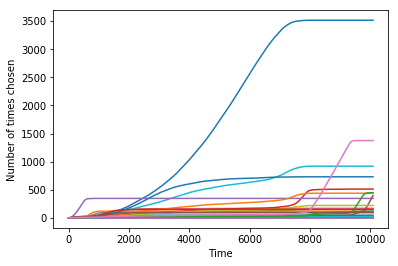

In [7]:
avg_active_choices = np.mean(active_choices, axis=0)

for i in range(k):
    plt.plot(avg_active_choices[i,:])
    plt.xlabel('Time')
    plt.ylabel('Number of times chosen')

top = np.argsort(avg_active_choices[:,-1])[::-1]

for i in top[:10]:
    print(idx2category[i])

In [8]:
most_chosen = np.argmax(active_choices[:, :, :], axis=1)

cutoff = 9

if mode == 'max':
    selection = ranked[:cutoff]
elif mode == 'min':
    selection = ranked[-cutoff:]
    selection = selection[::-1]
    
timestamps = [100, 200, 300, 400, 500]

table = np.zeros((cutoff+1, len(timestamps)))
    
for i, category in enumerate(selection):
    for j, timestamp in enumerate(timestamps):
        table[i,j] = np.mean(most_chosen[:,timestamp] == category)

table[cutoff,:] = 1 - np.sum(table, axis=0)

In [9]:
header = ' ' * 20 + ' '.join('%6i' % x for x in timestamps)
print(header)
idx2category = {row[0] : row[1] for _, row in pd.read_csv("data/jamia/labid2name.csv", header=None).iterrows()}

for i, row in enumerate(table):
    if i < cutoff:
        category = idx2category[selection[i]]
    else:
        category = 'OTHER'
    category_string = '{:20s}'.format(category)
    num_string = ' '.join('{:.04f}'.format(x) for x in row.tolist())
    print(category_string + num_string)

                       100    200    300    400    500
DizzyDentHearVision 0.5400 0.7600 0.9200 0.9600 0.9800
Diet                0.0100 0.0000 0.0000 0.0000 0.0000
Depression          0.0500 0.1300 0.0100 0.0000 0.0000
GeneralAnxieties    0.0200 0.0700 0.0600 0.0400 0.0200
MDLife              0.0000 0.0000 0.0000 0.0000 0.0000
OtherAddictions     0.0000 0.0000 0.0000 0.0000 0.0000
TestDiagnostics     0.0600 0.0100 0.0000 0.0000 0.0000
RiskyBehavior       0.0000 0.0000 0.0000 0.0000 0.0000
Exercise            0.0300 0.0000 0.0000 0.0000 0.0000
OTHER               0.2900 0.0300 0.0100 0.0000 0.0000


In [10]:
confidence_k = confidence_k.reshape(1, -1 , 1)
if mode == 'max':
    random_success = np.mean(np.argmax(confidence_k - random_thetas, axis=1) == selection[0], axis=0)
    active_success = np.mean(np.argmax(confidence_k - active_thetas, axis=1) == selection[0], axis=0)
elif mode == 'min':
    random_success = np.mean(np.argmin(confidence_k - random_thetas, axis=1) == selection[0], axis=0)
    active_success = np.mean(np.argmin(confidence_k - active_thetas, axis=1) == selection[0], axis=0)

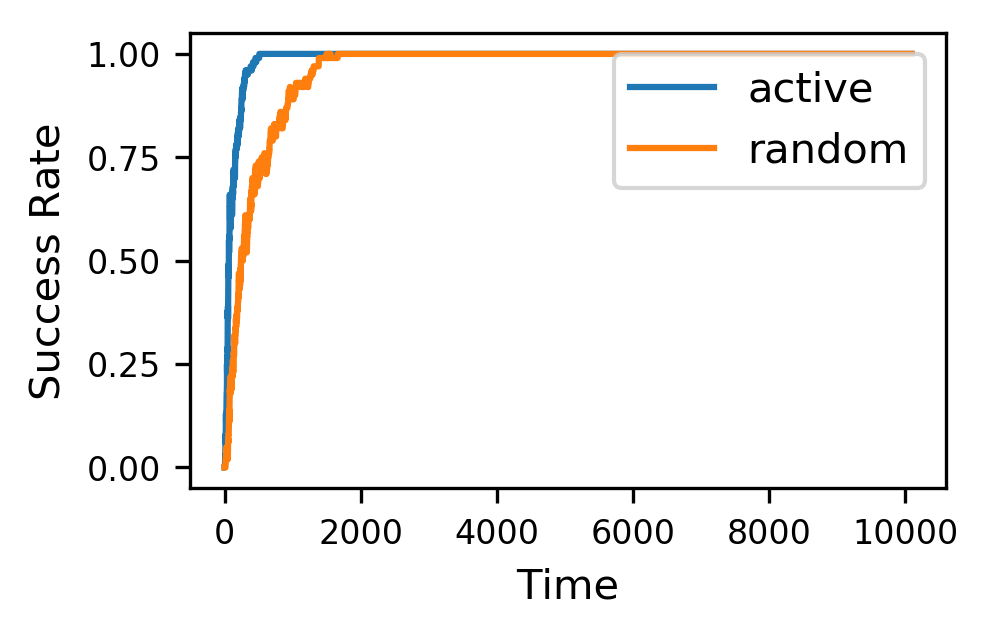

In [11]:
# If labels are getting cut off make the figsize smaller
plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH / GOLDEN_RATIO), dpi=300)

plt.plot(active_success, label='active')
plt.plot(random_success, label='random')
plt.xlabel('Time')
plt.ylabel('Success Rate')
plt.legend()


# FORMAT STUFF ##
plt.yticks(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)

plt.savefig("figures/active_jamia_calibration_bias_%s_runs_%d.pdf" % (mode, runs), format='pdf', dpi=300, bbox_inches='tight')
np.save('output/active_jamia_calibration_bias_%s_runs_%d_active_success' % (mode, runs), active_success)
np.save('output/active_jamia_calibration_bias_%s_runs_%d_random_success' % (mode, runs), random_success)

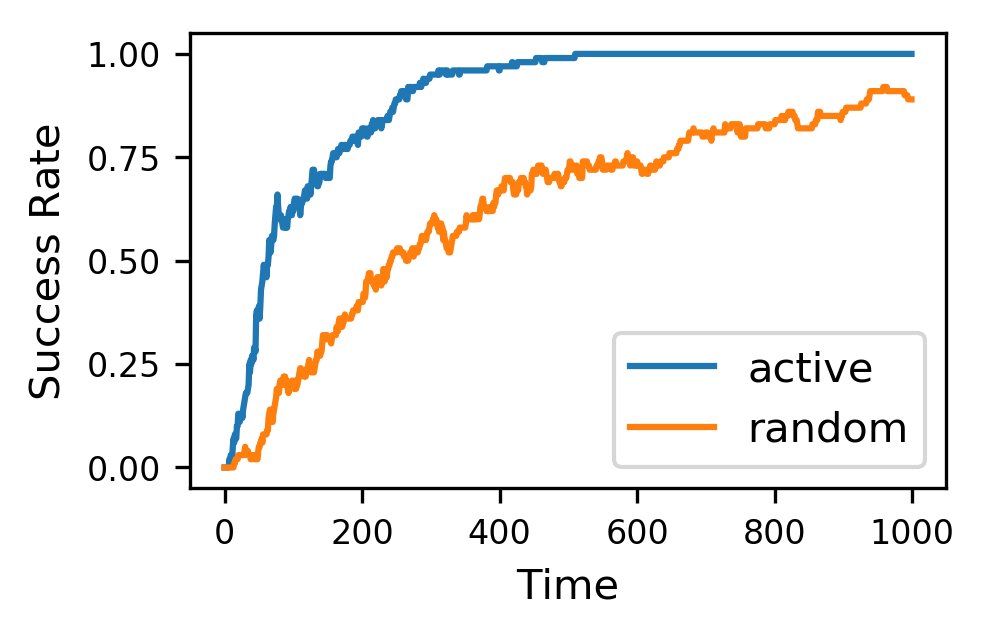

In [13]:
# If labels are getting cut off make the figsize smaller
plt.figure(figsize=(COLUMN_WIDTH, COLUMN_WIDTH / GOLDEN_RATIO), dpi=300)

plt.plot(active_success[:1000], label='active')
plt.plot(random_success[:1000], label='random')
plt.xlabel('Time')
plt.ylabel('Success Rate')
plt.legend()


# FORMAT STUFF ##
plt.yticks(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)

plt.savefig("figures/active_jamia_calibration_bias_%s_runs_%d_crop.pdf" % (mode, runs), format='pdf', dpi=300, bbox_inches='tight')